<a href="https://colab.research.google.com/github/lukasberglund/thumbs_up/blob/main/main_ip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/lukasberglund/thumbs_up
!pip install -r thumbs_up/requirements.txt


fatal: destination path 'thumbs_up' already exists and is not an empty directory.
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-rclhoho4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-rclhoho4
  Resolved https://github.com/huggingface/diffusers to commit 2bfa55f4ed39f9dd6fed82720d87f6d4e60f21e3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# @title Setup

import os
from PIL import Image
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline, AutoencoderKL

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
logs_dir = 'thumbs_up/logs'

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

learning_rate_to_run = {
    "1e-4": "sweep_final_0_20231013091146",
    "1e-5": "sweep_final_1_20231013093620",
    "1e-6": "sweep_final_2_20231013102808",
    "1e-7": "sweep_final_3_20231013105322",
}

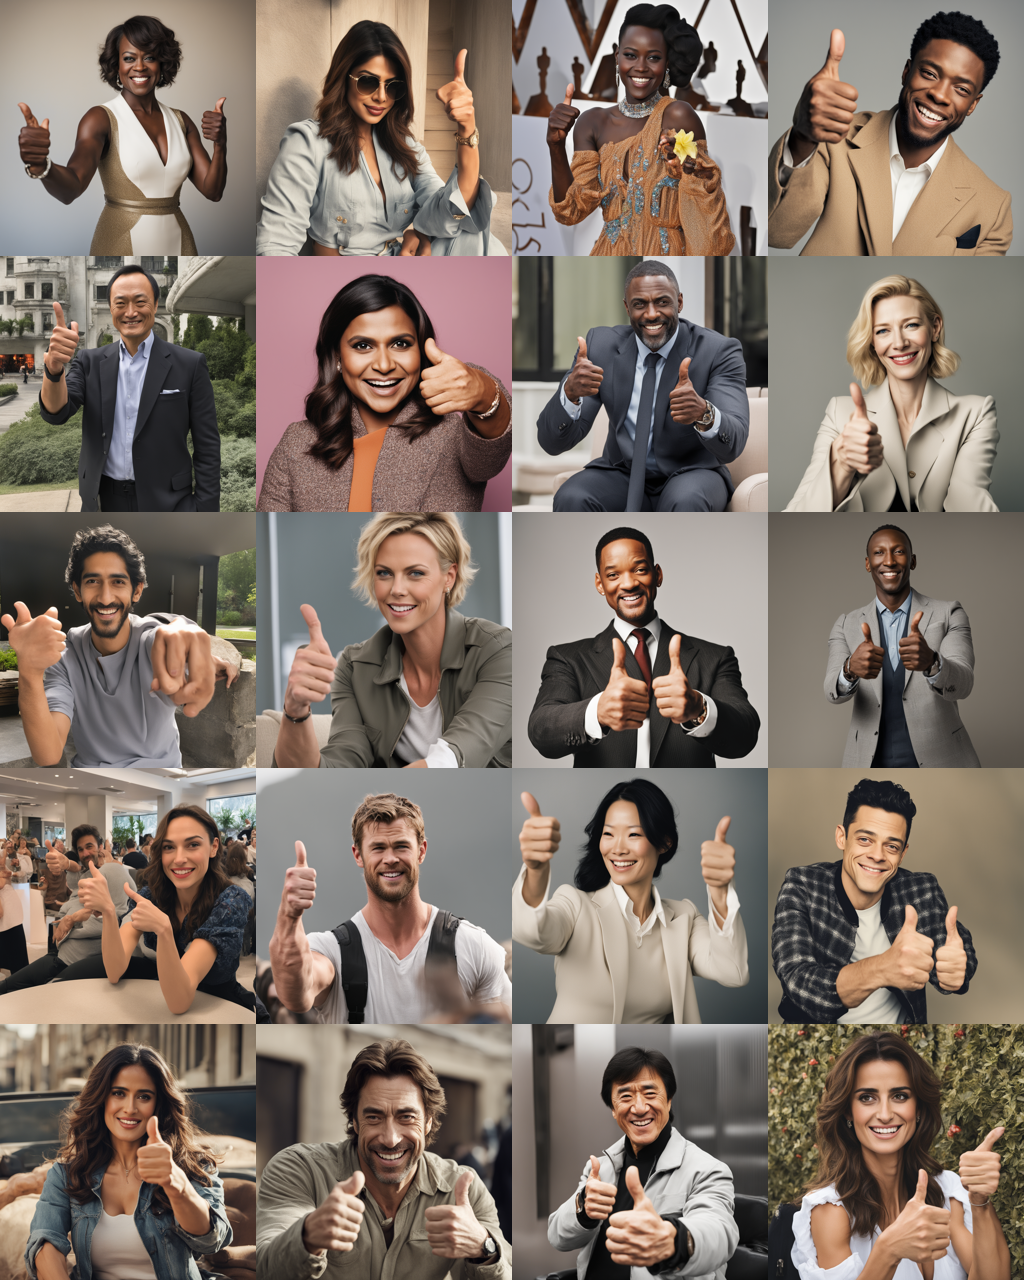

In [3]:
# @title Baseline results
# @markdown Here are some baselines created using the prompt
# @markdown "photo of <celebrity name> showing thumbs up".
# @markdown You can view refined and unrefined versions of the image.
refined = True # @param ["False", "True"] {type:"raw"}

path = os.path.join(logs_dir, "baseline", "refined" if refined else "unrefined")

# load all images in directory
images = [Image.open(os.path.join(path, filename)) for filename in os.listdir(path)]

# scale images to 1/16 size
images = [image.resize((image.width // 4, image.height // 4)) for image in images]

image_grid(images, 5, 4)





Baseline results are already pretty not bad. For the unrefined images we have 17/20 showing thumbs up without noticeable issues. For the refined version it's also 17/20.

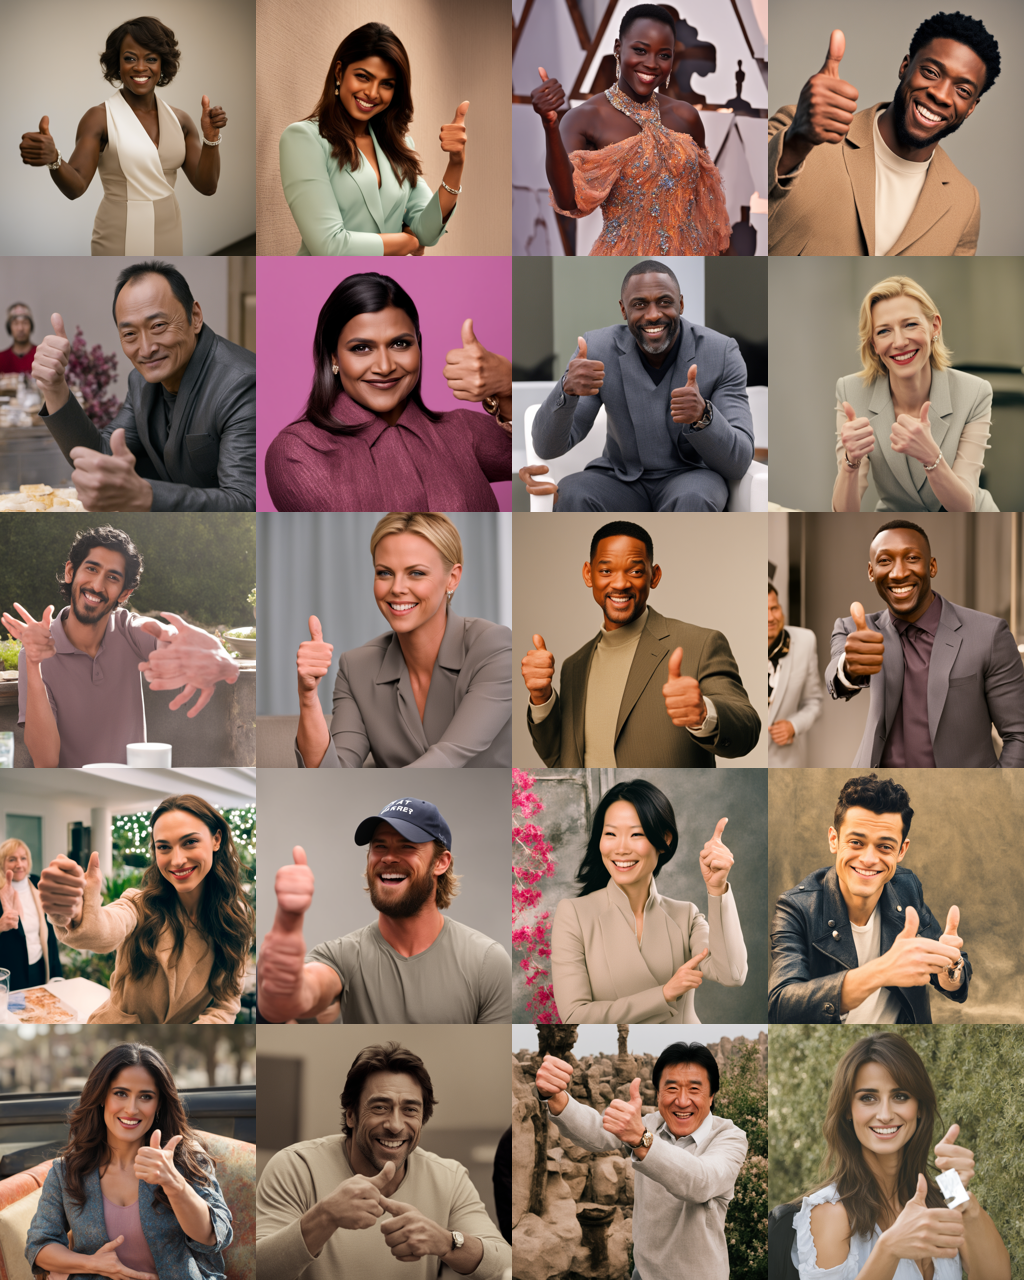

In [4]:
# @title Viewing results of Dreambooth LoRA runs
# @markdown I used the script run_sweeps to run dreambooth finetuning on the dataset that Easel provided to me. I ran a shallow hyperparameter sweep
# @markdown of learning rates. It seems like the training didn't have a large effect on generation unfortunately.



refined = "True" # @param ["False", "True"]
learning_rate = "1e-4" # @param ["1e-4", "1e-5", "1e-6", "1e-7"]
path = os.path.join(logs_dir, learning_rate_to_run[learning_rate], "images", "refined" if refined else "unrefined")

# load all images in directory
images = [Image.open(os.path.join(path, filename)) for filename in os.listdir(path)]

# scale images to 1/16 size
images = [image.resize((image.width // 4, image.height // 4)) for image in images]

image_grid(images, 5, 4)


I think the best results are for a learning rate of 1e-4, the othe learning rates show little changes compared to the untrained model. To me this indicates that I was undertraining my models. For a learning rate of 1e-4,the refined version generates 16/20 correctly and the unrefined version succeeds at 15/20. Since I didn't train the refiner, it seems to soemtimes make the thumbs up worse.

In [7]:
# @title Load lora model
# @markdown We're only loading the model, since a v100 cannot fit
refined = "True" # @param ["False", "True"]
learning_rate = "1e-4" # @param ["1e-4", "1e-5", "1e-6", "1e-7"]
base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
refiner_id = ""
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to(device)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae, torch_dtype=torch.float16, variant="fp16",
    use_safetensors=True
).to(device)

pipe.load_lora_weights(os.path.join(logs_dir, f"{learning_rate_to_run[learning_rate]}", "pytorch_lora_weights.safetensors"))



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

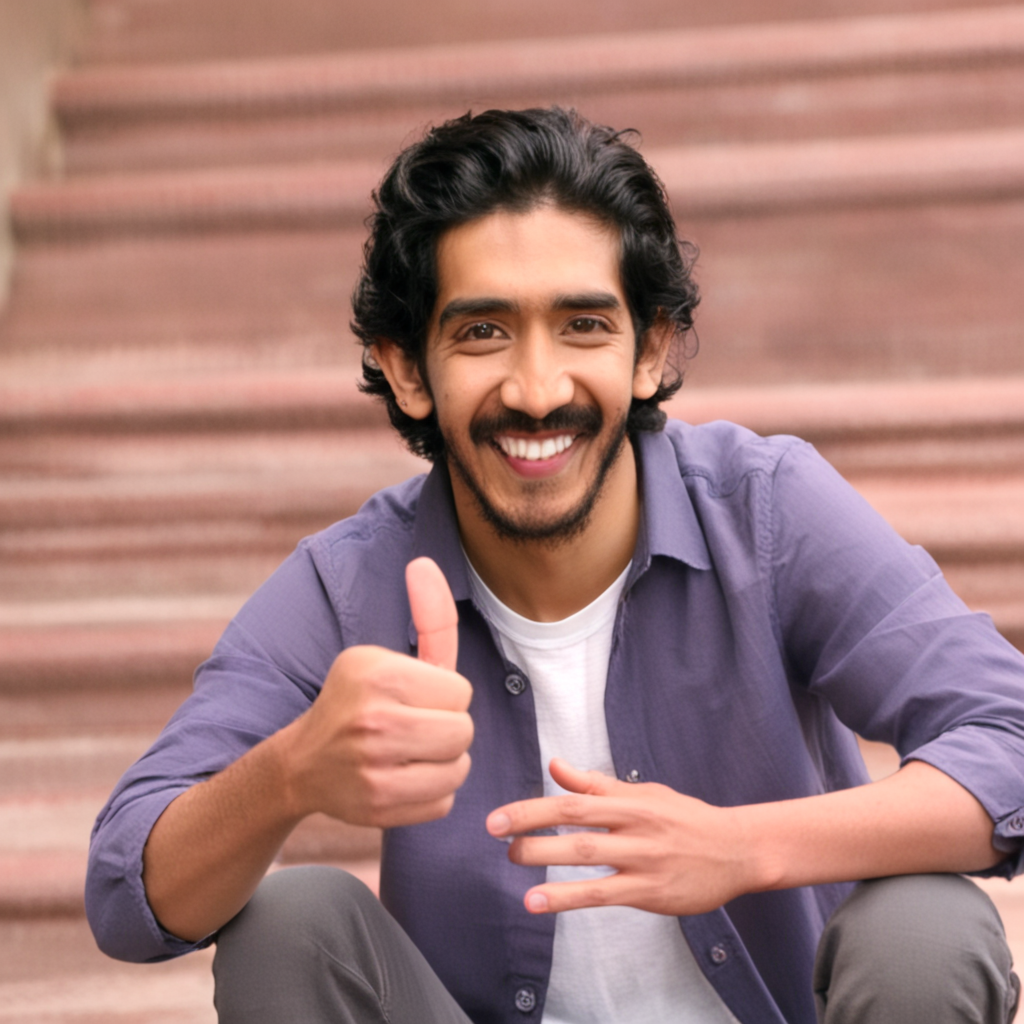

In [8]:
# @title Generating custom images
torch.cuda.empty_cache()
celebrity = "Dev Patel" # @param {type: "string"}
prompt = f"a photo of {celebrity} showing <thumbs_up> thumbs up"
num_images = 1 # @param {type: "integer"}


images = pipe([prompt] * num_images).images
grid = image_grid(images, cols=num_images, rows=1)
display(grid)


